#### Import the necessary packages

In [1]:
import pandas as pd
import numpy as np
import os
import tempfile
from datetime import datetime
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from math import sqrt,exp
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

#### Mount Drive and Import the data

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount = True)

Mounted at /gdrive


In [42]:
project_dir = "/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/"
working_dir = project_dir + "SRC/"
image_dir = project_dir + "data/Images/"
cropped_dir = project_dir + "data/Cementum_only_images"
%cd {working_dir} 
%pwd

/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/SRC


'/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/SRC'

In [5]:
data = pd.read_csv(project_dir + 'data/clean_meta.csv', index_col= 0)
print(data.shape)
data.head(10)

(2564, 7)


,ID,Tooth.Code,Age,Sex,ImgID,ImgName,eruption
0,1,44.0,80.25,0.0,138,001_44_NA_80.25_0138.jpg,10.0
1,1,44.0,80.25,0.0,139,001_44_NA_80.25_0139.jpg,10.0
2,1,44.0,80.25,0.0,368,001_44_NA_80.25_0368.jpg,10.0
3,1,44.0,80.25,0.0,369,001_44_NA_80.25_0369.jpg,10.0
4,2,12.0,46.00,2.0,140,002_12_2_46_0140.jpg,8.5
5,2,12.0,46.00,2.0,141,002_12_2_46_0141.jpg,8.5
6,2,12.0,46.00,2.0,142,002_12_2_46_0142.jpg,8.5
7,2,12.0,46.00,2.0,143,002_12_2_46_0143.jpg,8.5
8,2,12.0,46.00,2.0,144,002_12_2_46_0144.jpg,8.5
9,2,12.0,46.00,2.0,151,002_12_2_46_0151.jpg,8.5


#### Import the ResNet-50 model

In [67]:
conv_model = tf.keras.applications.resnet50.ResNet50(input_shape=(224,224,3),
                                                  include_top=False,
                                                  weights='imagenet',
                                                        )
conv_model.trainable = True
for layer in conv_model.layers:
  if(('bn' in layer.name)):
       layer.trainable = False
model = Sequential()
model.add(conv_model)
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1, activation = None))

##### This is to load any previous model checkpoints to speed up learning

In [ ]:
checkpoint_filepath = project_dir + 'models/checkpoint.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_filepath)
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)

G:/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/models\checkpoint_Large.ckpt


In [ ]:
model.load_weights(latest)

In [7]:
conv_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,483,521
Non-trainable params: 106,240
_________________________________________________________________


In [69]:
#Loss function needs to be the Mean_squared error
loss = "MeanSquaredError"

#metrics for measurement
metrics = ['RootMeanSquaredError']

#Optimizer is going to the Adam, because it is the best performing
Optimizer = Adam(learning_rate= 1e-5)

#### Compile the model (make it ready to learn

In [70]:
model.compile(optimizer= Optimizer, loss = loss, metrics= metrics)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,483,521
Non-trainable params: 106,240
_________________________________________________________________


#### Set up the train/test split in the data

In [15]:
x_col = 'ImgName' # column in the df with local paths to images
y_col = "Age" # column in the df with the names of the classes

print("'{}' column contains {} unique classes".format(y_col,data[y_col].unique().shape[0] ))

'Age' column contains 136 unique classes


In [16]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size = 0.3, random_state = 1313)
train_data, val_data = train_test_split(train_data, test_size = 0.2, random_state = 1313)

In [ ]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(1435, 7)
(359, 7)
(770, 7)


#### Image augmentation

In [17]:
IMG_SIZE = 224
batch_size = 32

#need to pass the class names to the .flow_from_dataframe method
train_classes = train_data[y_col].unique()
train_classes = np.sort(train_classes).tolist()

datagen_train=tf.keras.preprocessing.image.ImageDataGenerator(
                      rescale=1./255,
                      rotation_range=15,
                      #width_shift_range=0.2,
                      #height_shift_range=0.2,
                      shear_range=0.005,
                      #zoom_range=[0.9, 1.4],
                      horizontal_flip=True,
                     # vertical_flip=False,
                      brightness_range=(.8,1.2),
                      fill_mode='nearest',
                      )

train_generator=datagen_train.flow_from_dataframe(
    dataframe=train_data,
    directory=image_dir,
    shuffle=False,
    x_col=x_col,
    y_col=y_col,
  # save_to_dir=savepath + '/aug_images', 
    classes=train_classes,
    class_mode='raw',
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:220: UserWarning: `classes` will be ignored given the class_mode="raw"
  .format(self.class_mode))


Found 1435 validated image filenames.


In [23]:
datagen_val=tf.keras.preprocessing.image.ImageDataGenerator(
                      rescale=1./255
                      )

val_generator=datagen_val.flow_from_dataframe(
    dataframe=val_data,
    directory=image_dir, 
    x_col=x_col,
    y_col=y_col,
    class_mode='raw',
    classes=train_classes,
    shuffle=False,
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=batch_size)

test_generator = datagen_val.flow_from_dataframe(
    dataframe=test_data,
    directory=image_dir, 
    x_col=x_col,
    y_col=y_col,
    class_mode='raw',
    classes=train_classes,
    shuffle=False,
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=1)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:220: UserWarning: `classes` will be ignored given the class_mode="raw"
  .format(self.class_mode))


Found 359 validated image filenames.
Found 770 validated image filenames.


In [ ]:
import helper as hp

#### Callbacks

In [ ]:
#Tensorboard
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')

In [ ]:
#model checkpoint
checkpoint_filepath = project_dir + 'models/checkpoint.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_filepath)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [55]:
#EarlyStopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_root_mean_squared_error",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [12]:
#Reduce LR on Plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=1e-7)

In [ ]:
#CSV Logger
csv_logger = tf.keras.callbacks.CSVLogger("training.log", append = True)

#### First run

In [19]:
#define the step size
steps_train = round(train_generator.n / batch_size)
steps_val = round(val_generator.n / batch_size)
steps_test = round(test_generator.n / batch_size)

In [20]:
epochs = 50
callbacks = [reduce_lr, early_stop]

In [21]:
history = model.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=steps_train,
                    validation_data=val_generator,
                    callbacks = callbacks
                    ) 

Epoch 1/50
45/45 [==============================] - 939s 21s/step - loss: 825.7757 - root_mean_squared_error: 28.7363 - cosine_similarity: 1.0000 - val_loss: 161.9275 - val_root_mean_squared_error: 12.7251 - val_cosine_similarity: 1.0000
Epoch 2/50
45/45 [==============================] - 50s 1s/step - loss: 209.2647 - root_mean_squared_error: 14.4660 - cosine_similarity: 1.0000 - val_loss: 172.7841 - val_root_mean_squared_error: 13.1447 - val_cosine_similarity: 1.0000
Epoch 3/50
45/45 [==============================] - 50s 1s/step - loss: 204.2138 - root_mean_squared_error: 14.2903 - cosine_similarity: 1.0000 - val_loss: 158.6388 - val_root_mean_squared_error: 12.5952 - val_cosine_similarity: 1.0000
Epoch 4/50
45/45 [==============================] - 50s 1s/step - loss: 197.0826 - root_mean_squared_error: 14.0386 - cosine_similarity: 1.0000 - val_loss: 190.6699 - val_root_mean_squared_error: 13.8083 - val_cosine_similarity: 1.0000
Epoch 5/50
45/45 [==============================] - 50

#### Check it out

In [22]:
result = model.evaluate(test_generator, steps=steps_test)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

24/24 [==============================] - 393s 16s/step - loss: 188.3880 - root_mean_squared_error: 13.7255 - cosine_similarity: 1.0000
Test-set classification accuracy: 1372.55%


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
preds = model.predict(test_generator)

[Text(0, 0.5, 'Predicted Age'),
 Text(0.5, 0, 'True Age'),
 Text(0.5, 1.0, 'True vs Predicted Age')]

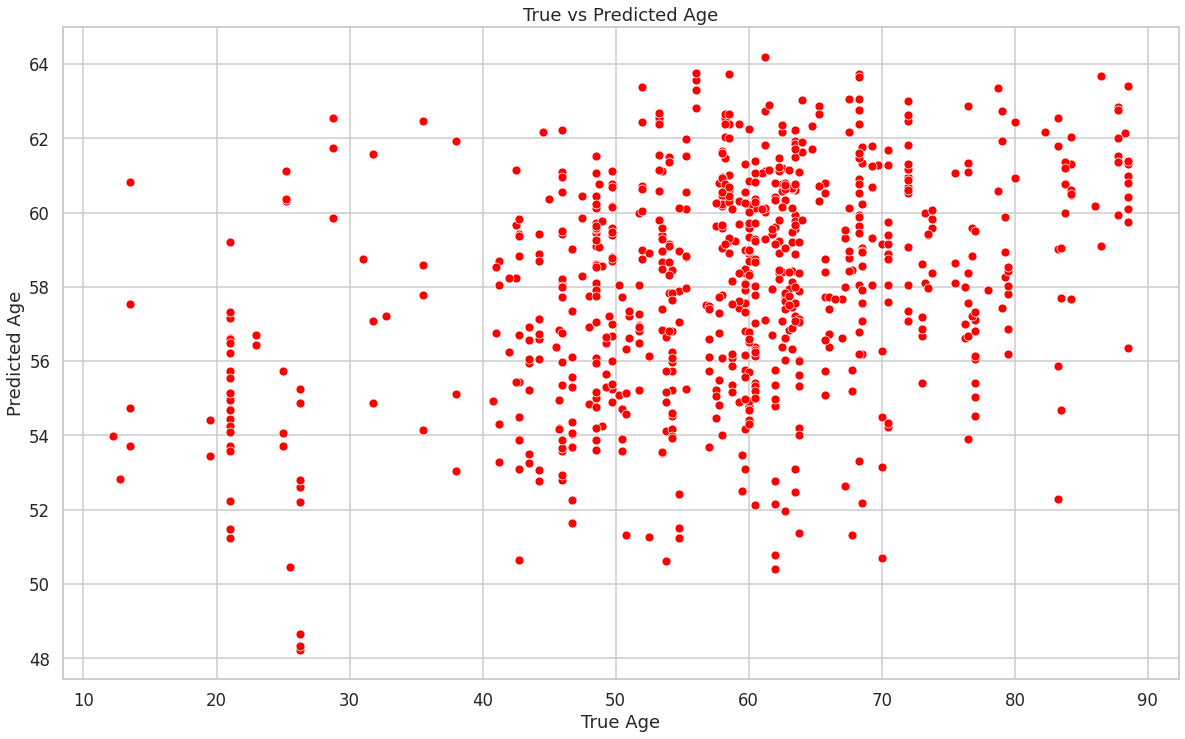

In [39]:
fig = plt.gcf()
sns.set_style("whitegrid")
sns.set_context("talk")
fig.set_size_inches(20, 12)
ax = sns.scatterplot(x = test_data['Age'], y = preds.flatten(), color = "red", edgecolor = 'w', s = 80)
ax.set(xlabel = "True Age", ylabel = "Predicted Age", Title  = "True vs Predicted Age")

#### Try with Cementum-only Iages

This is the same code as above, but for a collection of cropped images that we created ourselves. This is not necessary if images have already been curated

In [43]:
cropped_dir

'/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/data/Cementum_only_images'

In [44]:
import glob
current_folder_content = glob.glob(cropped_dir + "/*")
#current_folder_content = Path.glob(image_dir_cropped, "/*")
len(current_folder_content)

2561

In [45]:
image_name_list= [] #contain all image names

for image in current_folder_content:
  image_name = image.split('/', 10)[-1]
  image_name_list.append(image_name)

print(len(image_name_list))
image_name_list[:5]

2561


['253_22_2_68.25_2273.jpg',
 '253_22_2_68.25_7214.jpg',
 '254_11_2_35.5_2114.jpg',
 '254_11_2_35.5_2224.jpg',
 '254_11_2_35.5_2225.jpg']

Resample the dataset

In [46]:
clean_data = data[data['ImgName'].isin(image_name_list)]

In [47]:
clean_data

,ID,Tooth.Code,Age,Sex,ImgID,ImgName,eruption
0,1,44.0,80.25,0.0,138,001_44_NA_80.25_0138.jpg,10.0
1,1,44.0,80.25,0.0,139,001_44_NA_80.25_0139.jpg,10.0
2,1,44.0,80.25,0.0,368,001_44_NA_80.25_0368.jpg,10.0
3,1,44.0,80.25,0.0,369,001_44_NA_80.25_0369.jpg,10.0
4,2,12.0,46.00,2.0,140,002_12_2_46_0140.jpg,8.5
...,...,...,...,...,...,...,...
2558,540,12.0,44.00,1.0,3835,540_12_1_44_3835.jpg,8.0
2559,571,44.0,22.50,1.0,3708,571_44_1_22.5_3708.jpg,10.5
2560,571,44.0,22.50,1.0,3710,571_44_1_22.5_3710.jpg,10.5
2561,572,24.0,22.50,1.0,3706,572_24_1_22.5_3706.jpg,11.0


Train/test split once again

In [48]:
train_data_clean, test_data_clean = train_test_split(clean_data, test_size = 0.3, random_state = 1313)
train_data_clean, val_data_clean = train_test_split(train_data_clean, test_size = 0.2, random_state = 1313)

In [49]:
print(train_data_clean.shape)
print(val_data_clean.shape)
print(test_data_clean.shape)

(1396, 7)
(350, 7)
(749, 7)


##### Image aug

In [52]:
IMG_SIZE = 224
batch_size = 8

#need to pass the class names to the .flow_from_dataframe method
train_classes_clean = train_data_clean[y_col].unique()
train_classes_clean = np.sort(train_classes_clean).tolist()

datagen_train=tf.keras.preprocessing.image.ImageDataGenerator(
                      rescale=1./255,
                      rotation_range=10,
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.005,
                      #zoom_range=[0.9, 1.4],
                      horizontal_flip=True,
                     # vertical_flip=False,
                      brightness_range=(.7,1.3),
                      fill_mode='nearest',
                      )

train_generator_clean=datagen_train.flow_from_dataframe(
    dataframe=train_data_clean,
    directory=cropped_dir,
    shuffle=True,
    x_col=x_col,
    y_col=y_col,
  # save_to_dir=savepath + '/aug_images', 
    classes=train_classes_clean,
    class_mode='raw',
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:220: UserWarning: `classes` will be ignored given the class_mode="raw"
  .format(self.class_mode))


Found 1396 validated image filenames.


In [79]:
datagen_val=tf.keras.preprocessing.image.ImageDataGenerator(
                      rescale=1./255
                      )

val_generator_clean=datagen_val.flow_from_dataframe(
    dataframe=val_data_clean,
    directory=cropped_dir, 
    x_col=x_col,
    y_col=y_col,
    class_mode='raw',
    classes=train_classes_clean,
    shuffle=True,
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=batch_size)

test_generator_clean = datagen_val.flow_from_dataframe(
    dataframe=test_data_clean,
    directory=cropped_dir, 
    x_col=x_col,
    y_col=y_col,
    class_mode='raw',
    classes=train_classes_clean,
    shuffle=True,
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=1)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:220: UserWarning: `classes` will be ignored given the class_mode="raw"
  .format(self.class_mode))


Found 350 validated image filenames.
Found 749 validated image filenames.


##### Clean Run

In [83]:
#define the step size
steps_train_clean = round(train_generator_clean.n / batch_size)
steps_val_clean = round(val_generator_clean.n / batch_size)
steps_test_clean = round(test_generator_clean.n / 1)

In [62]:
batch_size = 32
valid_batch_size = 32

In [71]:
epochs = 50
callbacks = [reduce_lr,early_stop]

In [72]:
history_clean = model.fit(train_generator_clean,
                    steps_per_epoch=steps_train_clean,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=val_generator_clean,
                    validation_steps=steps_val_clean
                    ) 

Epoch 1/50
44/44 [==============================] - 53s 1s/step - loss: 899.4408 - root_mean_squared_error: 29.9907 - val_loss: 167.0554 - val_root_mean_squared_error: 12.9250
Epoch 2/50
44/44 [==============================] - 40s 900ms/step - loss: 175.9419 - root_mean_squared_error: 13.2643 - val_loss: 165.0670 - val_root_mean_squared_error: 12.8478
Epoch 3/50
44/44 [==============================] - 37s 842ms/step - loss: 169.9489 - root_mean_squared_error: 13.0364 - val_loss: 162.6989 - val_root_mean_squared_error: 12.7553
Epoch 4/50
44/44 [==============================] - 30s 688ms/step - loss: 178.0252 - root_mean_squared_error: 13.3426 - val_loss: 179.1157 - val_root_mean_squared_error: 13.3834
Epoch 5/50
44/44 [==============================] - 23s 519ms/step - loss: 172.0561 - root_mean_squared_error: 13.1170 - val_loss: 160.2135 - val_root_mean_squared_error: 12.6575
Epoch 6/50
44/44 [==============================] - 20s 444ms/step - loss: 168.4319 - root_mean_squared_erro

In [84]:
pred = model.predict(test_generator_clean, steps= steps_test_clean)

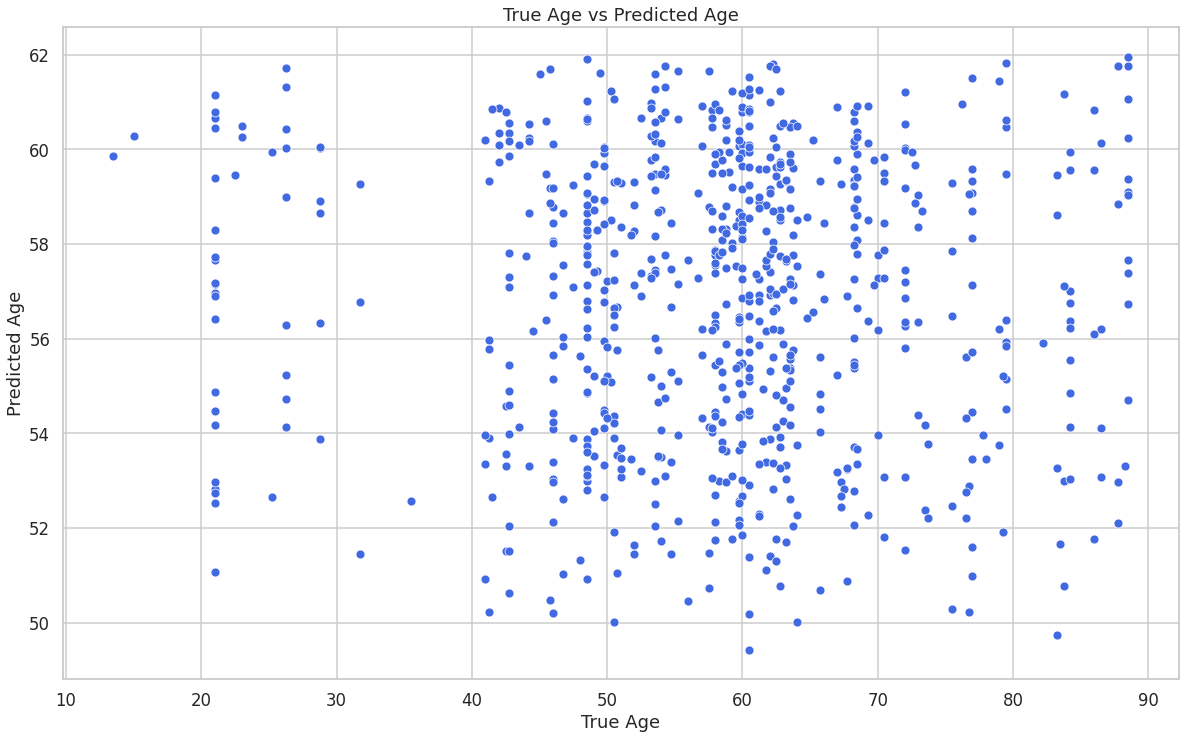

In [86]:
fig = plt.gcf()
sns.set_style("whitegrid")
fig.set_size_inches(20, 12)
sns.set_context("talk")
ax = sns.scatterplot(x = test_data_clean['Age'], y = pred.flatten(), color = 'royalblue', edgecolor = 'w', s = 80,)
ax.set(xlabel='True Age', ylabel='Predicted Age', title = "True Age vs Predicted Age")
plt.savefig('initial_run.png', dpi = 180)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=logs

In [ ]:
conv_model_2 = tf.keras.applications.resnet50.ResNet50(input_shape=(224,224,3),
                                                  include_top=False,
                                                  weights='imagenet',
                                                        )
conv_model_2.trainable = True
for layer in conv_model_2.layers:
  if(('bn' in layer.name)):
       layer.trainable = False
model_2 = Sequential()
model_2.add(conv_model_2)
model_2.add(tf.keras.layers.Dropout(0.2))
model_2.add(tf.keras.layers.GlobalAveragePooling2D())
model_2.add(tf.keras.layers.Dense(1, activation = None))

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)

In [ ]:
model_2.load_weights(latest)

In [ ]:
model_2.predict(test_generator[0][0])